# Preparing the instance

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.4.0


In [ ]:
!pip install tensorflow==2.4.0
import tensorflow
print(tensorflow.__version__)

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 2.9 MB 37.0 MB/s 
     |████████████████████████████████| 462 kB 48.4 MB/s 
     |████████████████████████████████| 3.8 MB 36.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=b5d3f05b3baa3bccb7c76048299529fd2f42eb0b8df01ebe906725f344f8c1cb
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

2.7.0


In [ ]:
!nvidia-smi
!nvcc --version

Wed Dec  8 18:13:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!sudo apt install cuda-toolkit-11-2
#!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-ubuntu1604.pin
#!sudo mv cuda-ubuntu1604.pin /etc/apt/preferences.d/cuda-repository-pin-600
#!sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/7fa2af80.pub
#!sudo add-apt-repository "deb http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/ /"
#!sudo apt-get update
#!sudo apt-get -y install cuda
#!sudo apt --fix-broken install
#!sudo apt install cuda-cudart-11-2
#import os
#os.environ['PATH'] = '/usr/local/cuda-11.2/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin'
#os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64:/usr/lib64-nvidia'
#!cp "/content/drive/My Drive/cudnn-11.2-linux-x64-v8.1.0.77.tgz" "/content/cudnn-8.1.tgz"
#!mkdir cudnn
#!tar -C cudnn/ -zxvf cudnn-8.1.tgz
#!rm -f /content/cudnn-8.1.tgz
#%cd cudnn/
#!sudo mv cuda/include/cudnn*.h /usr/local/cuda-11.2/include
#!sudo mv cuda/lib64/libcudnn* /usr/local/cuda-11.2/lib64
#!sudo chmod a+r /usr/local/cuda-11.2/include/cudnn*.h /usr/local/cuda-11.2/lib64/libcudnn*
#!sudo ldconfig
#%cd /content/

# TinyML with Wio Terminal Course 4: Weather prediction 
by Dmitry Maslov
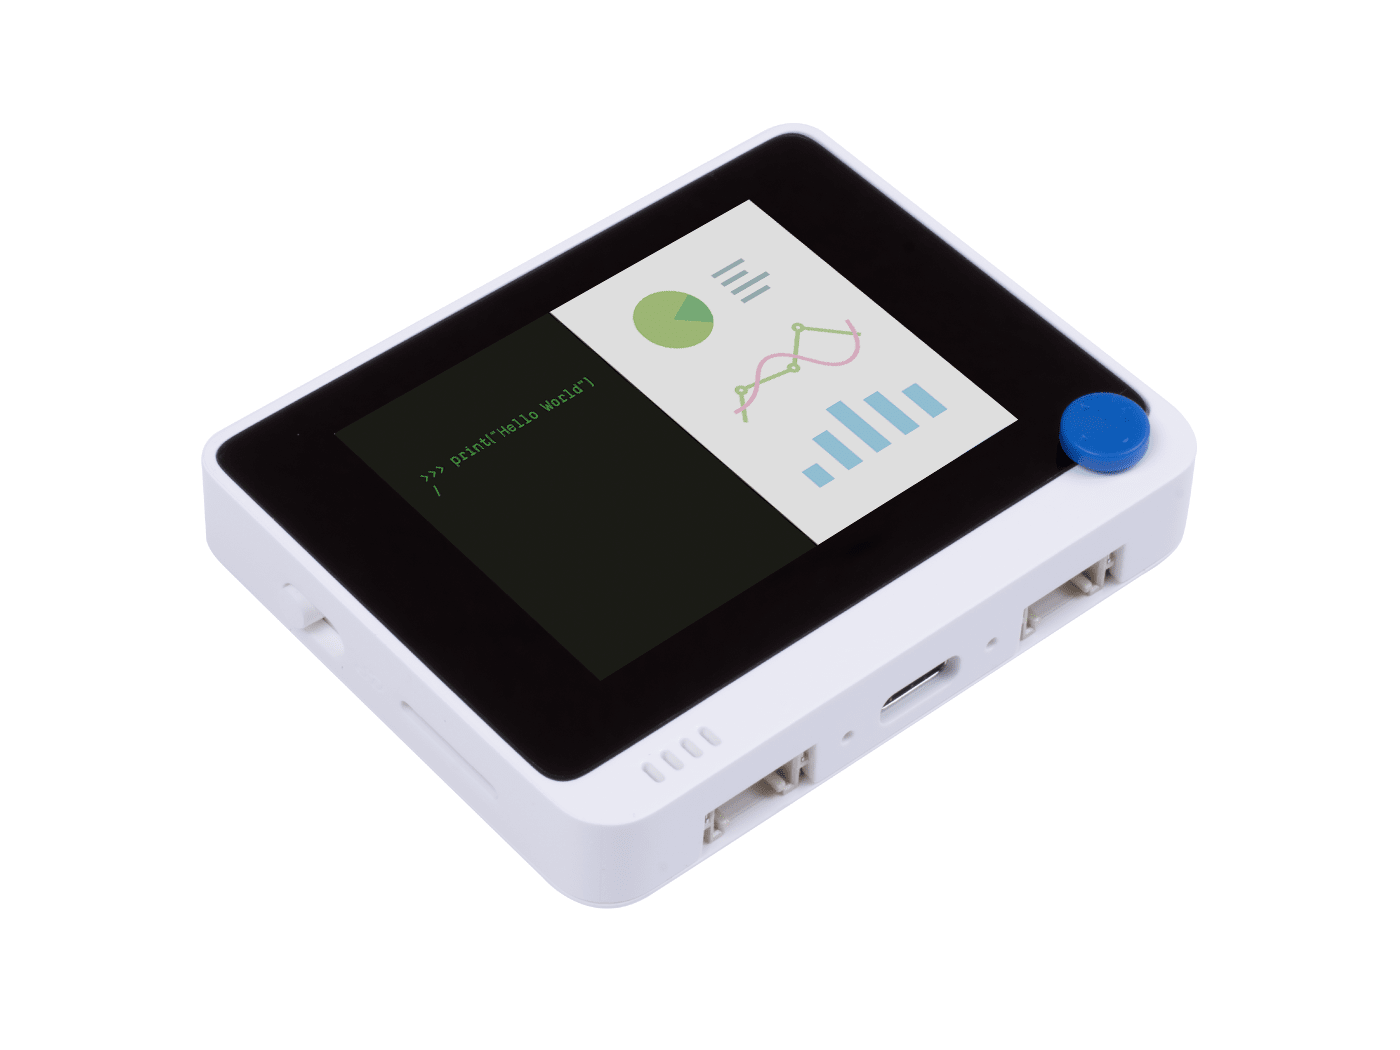

Link to the video:
https://youtu.be/qbpVltzvL6Q

Link to the article:


We start by downloading the dataset from Kaggle - you will need to create (or log into) Kaggle account and create API token. To do that, click on your profile pic -> Account, scroll down a bit and you'll see Create New API token button.
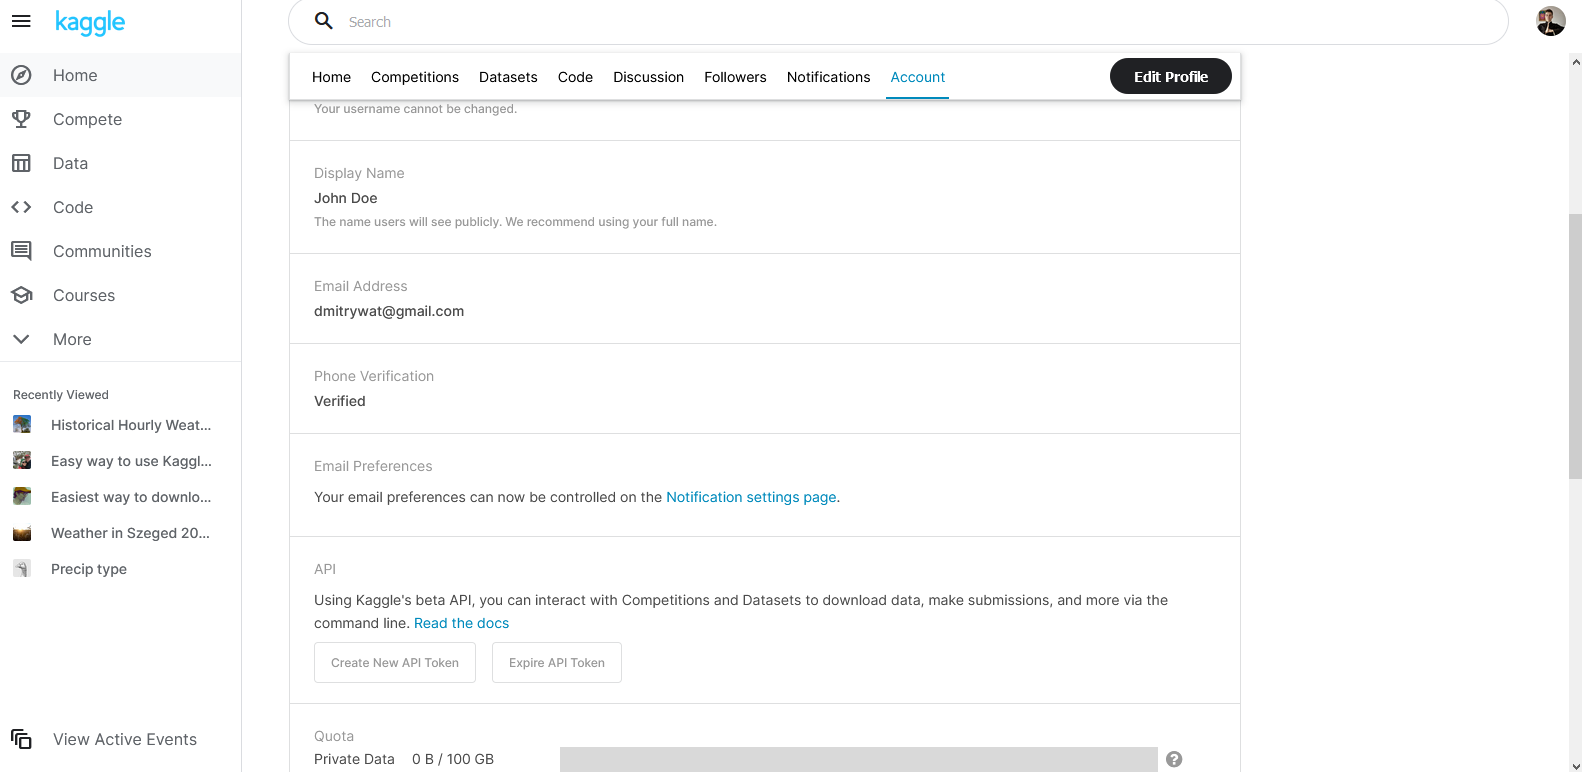
Download the JSON file and place it in Google Drive Kaggle folder.


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
!kaggle datasets download -d selfishgene/historical-hourly-weather-data

historical-hourly-weather-data.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip it to /content.

In [ ]:
!unzip -qq /content/historical-hourly-weather-data.zip

replace city_attributes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace city_attributes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In the next cell we create a training folder, where we'll put model files later. Now it is time to examine the dataset and do some preliminary cleaning. We use pandas to read csv files, dropping all the columns except for the city we're interested in - in this case it's Miami. 

Then you can notice (or can't - on the first time training the model I missed this fact), that dataset has different number of rows for different weather conditions. In other words, for example for Miami, there are more data points in the end of the .csv file for temperature, than there is for humidity. The most complete column is weather description. It's bad, but not horrible, since our data measurements were taken just one hour apart, we can "inpaint" the holes.

In [ ]:
import pandas as pd
import os
from datetime import datetime

window_size = 24
epochs = 200
batch_size = 128

train_date = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
root_path = os.path.join('/content/drive/MyDrive/projects/weather/', train_date)
if not os.path.isdir(root_path): os.makedirs(root_path)

df_temp = pd.read_csv('temperature.csv', usecols = ['San Francisco'])
df_temp = df_temp - 273.15
df_humid = pd.read_csv('humidity.csv', usecols = ['San Francisco'])
df_pres = pd.read_csv('pressure.csv', usecols = ['San Francisco'])
df_desc = pd.read_csv('weather_description.csv', usecols = ['San Francisco'])

df_list = [df_temp, df_humid, df_pres, df_desc]
missing_rows = []

for df in df_list: 
  print(df.isnull().values.sum())

for df in df_list: 
  df.drop(df.tail(793).index, inplace=True)
  df.drop(df.head(1).index, inplace=True)
  df.reset_index(inplace = True, drop = True)
  print(df)
  print("Indexes of nan values:", list(df.loc[pd.isna(df["San Francisco"]), :].index))

793
942
815
793
       San Francisco
0          16.330000
1          16.324993
2          16.310618
3          16.296243
4          16.281869
...              ...
44454      21.900000
44455      23.910000
44456      25.990000
44457      27.410000
44458      27.910000

[44459 rows x 1 columns]
Indexes of nan values: []
       San Francisco
0               88.0
1               87.0
2               86.0
3               85.0
4               84.0
...              ...
44454           34.0
44455           28.0
44456           25.0
44457           22.0
44458           20.0

[44459 rows x 1 columns]
Indexes of nan values: [851, 939, 968, 969, 1076, 1203, 1376, 1907, 1909, 1910, 1923, 1924, 1925, 1938, 1947, 2202, 2203, 2266, 2453, 2462, 2467, 2498, 2512, 2513, 2561, 2562, 2565, 2567, 2568, 2569, 2596, 2598, 2694, 2728, 2900, 2971, 3186, 3202, 3427, 3430, 3431, 3464, 3523, 3585, 3597, 3600, 3988, 4083, 4084, 4085, 4168, 4281, 4410, 4455, 4526, 4587, 4589, 4660, 4661, 4662, 4667, 4668, 4686, 4687

Here we use Pandas built-in interpolate function, which performs linear interpolation at missing data points. You can read more about it here

https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

After interpolation, all the missing values are gone.

In [ ]:
for df in df_list[:3]: 
  df.interpolate(inplace=True)
  print(df)
  print(list(df.loc[pd.isna(df["San Francisco"]), :].index))

       San Francisco
0          16.330000
1          16.324993
2          16.310618
3          16.296243
4          16.281869
...              ...
44454      21.900000
44455      23.910000
44456      25.990000
44457      27.410000
44458      27.910000

[44459 rows x 1 columns]
[]
       San Francisco
0               88.0
1               87.0
2               86.0
3               85.0
4               84.0
...              ...
44454           34.0
44455           28.0
44456           25.0
44457           22.0
44458           20.0

[44459 rows x 1 columns]
[]
       San Francisco
0             1009.0
1             1009.0
2             1009.0
3             1009.0
4             1009.0
...              ...
44454         1016.0
44455         1015.0
44456         1014.0
44457         1014.0
44458         1013.0

[44459 rows x 1 columns]
[]


After examining the dataset, we see that weather description column has 25 different labels - way above our TinyML model pay grade. We need to simplify it down to 4 basic weather types: cloudy, sunny, foggy and rainy. The replace function will print out the strings, that are absent from the dictionary. If you're using a different dataset, you will need to change the dictionary values.

In [ ]:
labels = df_desc['San Francisco'].unique()
print(labels)

weather_types = {'cloudy':['broken clouds', 'overcast clouds', 'scattered clouds', 'few clouds'],
                 'rainy':['light intensity drizzle', 'light rain', 'moderate rain', 'thunderstorm with heavy rain', 'heavy intensity rain',
                          'proximity thunderstorm', 'thunderstorm with light rain', 'thunderstorm', 'squalls', 'thunderstorm with rain', 'very heavy rain', 'proximity shower rain',
                          'drizzle', 'light intensity shower rain', 'shower rain', 'tornado'],
                 'sunny':['sky is clear'],
                 'foggy':['mist', 'haze', 'fog', 'smoke']}

def replace(content):
  for weather_type in weather_types.keys():
    for weather in weather_types[weather_type]:
      if content == weather:      
        return weather_type
  print(content)

df_desc['San Francisco'] = df_desc['San Francisco'].map(replace)  

print(df_desc)

labels = df_desc['San Francisco'].unique()
print(labels)

['light rain' 'sky is clear' 'haze' 'scattered clouds' 'overcast clouds'
 'broken clouds' 'mist' 'few clouds' 'fog' 'proximity thunderstorm'
 'light intensity drizzle' 'moderate rain' 'thunderstorm'
 'heavy intensity rain' 'thunderstorm with heavy rain'
 'proximity shower rain' 'heavy intensity drizzle' 'heavy snow' 'drizzle'
 'thunderstorm with rain' 'thunderstorm with light rain' 'very heavy rain'
 'proximity thunderstorm with rain' 'light intensity shower rain' 'smoke'
 'shower rain' 'squalls' 'light snow']
heavy intensity drizzle
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy snow
heavy sno

Next, we concatenate the four data frames into one. We skip the last window_size number of rows from input data dataframes, because we don't have weather description for them. For weather description dataframe we take the rows starting with window size index. So the data we get after concatenation is 

0_hour_temperature 0_hour_humidity 0_hour_pressure 25th_hour_description

In [ ]:
frames = [df_temp[:-window_size], df_humid[:-window_size], df_pres[:-window_size], df_desc[window_size:].reset_index(drop = True)]
df = pd.concat(frames, axis=1)
df.columns = ['temp', 'humid', 'pres', 'type']

print("First 50 rows: ", df[0:50])
print("Last 50 rows: ", df[-50:])

print(df['temp'].isnull().sum())
print(df['humid'].isnull().sum())
print(df['pres'].isnull().sum())
print(df['type'].isnull().sum())

First 50 rows:           temp  humid    pres    type
0   16.330000   88.0  1009.0   sunny
1   16.324993   87.0  1009.0   sunny
2   16.310618   86.0  1009.0   sunny
3   16.296243   85.0  1009.0   foggy
4   16.281869   84.0  1009.0   foggy
5   16.267494   83.0  1010.0  cloudy
6   16.253119   82.0  1010.0  cloudy
7   16.238745   81.0  1010.0   foggy
8   16.224370   80.0  1010.0  cloudy
9   16.209995   79.0  1011.0   sunny
10  16.195621   78.0  1011.0   sunny
11  16.181246   77.0  1011.0   sunny
12  16.166871   76.0  1011.0   sunny
13  16.152496   75.0  1012.0   sunny
14  16.138122   74.0  1012.0   sunny
15  16.123747   73.0  1012.0   sunny
16  16.109372   72.0  1012.0   sunny
17  16.094998   71.0  1013.0   foggy
18  16.080623   70.0  1013.0  cloudy
19  16.066248   69.0  1013.0  cloudy
20  16.051874   68.0  1013.0   sunny
21  16.037499   67.0  1014.0   sunny
22  16.023124   66.0  1014.0  cloudy
23  16.008749   65.0  1014.0  cloudy
24  15.994375   64.0  1014.0   sunny
25  15.980000   63.0  

Now, simplifying weather types into four basic groups has a distinct disadvantage of loosing some of information - for example there is a huge difference between 

light rain

and 

thunderstorm with heavy rain

Perhaps we could somehow alleviate the problem, by adding another type of data, precipitation, which we can calculate by dividing number occurrences of rainy weather by total number of data points in the time window. Let's say we had 2 rainy hours within 24 hour window, then precipitation will be set to 0.083 or 8.3 percent. If we had a long rain however (say, 12 hours of rain within 24 hours), the precipitation will reflect that - the value we'll get in this case is 50%.

In [ ]:
df_test = df[:100]
df_test.insert(4, "precip", None, True) 

for index, row in df_test.iterrows():
  if index == len(df_test) - window_size:
    break
  print(index)  
  print(df_test.loc[index:index+window_size-1, ('type')])
  value = df_test.loc[index:index+window_size-1, ('type')].isin(['rainy']).sum(axis=0)/window_size
  df_test['precip'][index] = value

print(df_test[:])

0
0      sunny
1      sunny
2      sunny
3      foggy
4      foggy
5     cloudy
6     cloudy
7      foggy
8     cloudy
9      sunny
10     sunny
11     sunny
12     sunny
13     sunny
14     sunny
15     sunny
16     sunny
17     foggy
18    cloudy
19    cloudy
20     sunny
21     sunny
22    cloudy
23    cloudy
Name: type, dtype: object
1
1      sunny
2      sunny
3      foggy
4      foggy
5     cloudy
6     cloudy
7      foggy
8     cloudy
9      sunny
10     sunny
11     sunny
12     sunny
13     sunny
14     sunny
15     sunny
16     sunny
17     foggy
18    cloudy
19    cloudy
20     sunny
21     sunny
22    cloudy
23    cloudy
24     sunny
Name: type, dtype: object
2
2      sunny
3      foggy
4      foggy
5     cloudy
6     cloudy
7      foggy
8     cloudy
9      sunny
10     sunny
11     sunny
12     sunny
13     sunny
14     sunny
15     sunny
16     sunny
17     foggy
18    cloudy
19    cloudy
20     sunny
21     sunny
22    cloudy
23    cloudy
24     sunny
25     foggy
Name: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In the last cell we just tested the precipitation calculation, now we apply it to the whole dataset.

In [ ]:
df.insert(4, "precip", None, True) 

for index, row in df.iterrows():
  if index == len(df) - window_size:
    break
  value = df.loc[index:index+window_size-1, ('type')].isin(['rainy']).sum(axis=0)/window_size
  df['precip'][index] = value

print("First 50 rows: ", df[0:50])
print("Last 50 rows: ", df[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


First 50 rows:           temp  humid    pres    type precip
0   16.330000   88.0  1009.0   sunny      0
1   16.324993   87.0  1009.0   sunny      0
2   16.310618   86.0  1009.0   sunny      0
3   16.296243   85.0  1009.0   foggy      0
4   16.281869   84.0  1009.0   foggy      0
5   16.267494   83.0  1010.0  cloudy      0
6   16.253119   82.0  1010.0  cloudy      0
7   16.238745   81.0  1010.0   foggy      0
8   16.224370   80.0  1010.0  cloudy      0
9   16.209995   79.0  1011.0   sunny      0
10  16.195621   78.0  1011.0   sunny      0
11  16.181246   77.0  1011.0   sunny      0
12  16.166871   76.0  1011.0   sunny      0
13  16.152496   75.0  1012.0   sunny      0
14  16.138122   74.0  1012.0   sunny      0
15  16.123747   73.0  1012.0   sunny      0
16  16.109372   72.0  1012.0   sunny      0
17  16.094998   71.0  1013.0   foggy      0
18  16.080623   70.0  1013.0  cloudy      0
19  16.066248   69.0  1013.0  cloudy      0
20  16.051874   68.0  1013.0   sunny      0
21  16.037499   

Next, we re-arrange the data in weather description column - to get the weather description for the whole window_size period we find the value that has most occurrences in the time window and set cell value to it. For example if following the first cell within 24 hour period we have 20 cloudy hours, 1 rainy and 3 foggy, we would set the value for this cell to cloudy. Then repeat the same procedure for every cell in type column. After transformation our data looks like this:

0_hour_temperature 0_hour_humidity 0_hour_pressure 25-49th_hour_average_type 25-49th_hour_precipitaion_percentage


In [ ]:
for index, row in df.iterrows():
  if index == len(df) - window_size:
    break
  value = df.loc[index:index+window_size-1, ('type')].value_counts().idxmax()
  df['type'][index] = value

labels = df.type.unique()

print(labels)
print("First 50 rows: \n", df[0:50])
print("Last 50 rows: \n", df[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['sunny' 'foggy' 'cloudy' 'rainy']
First 50 rows: 
          temp  humid    pres    type precip
0   16.330000   88.0  1009.0   sunny      0
1   16.324993   87.0  1009.0   sunny      0
2   16.310618   86.0  1009.0   sunny      0
3   16.296243   85.0  1009.0   sunny      0
4   16.281869   84.0  1009.0   sunny      0
5   16.267494   83.0  1010.0   sunny      0
6   16.253119   82.0  1010.0   sunny      0
7   16.238745   81.0  1010.0   sunny      0
8   16.224370   80.0  1010.0   sunny      0
9   16.209995   79.0  1011.0   sunny      0
10  16.195621   78.0  1011.0   sunny      0
11  16.181246   77.0  1011.0   sunny      0
12  16.166871   76.0  1011.0   sunny      0
13  16.152496   75.0  1012.0   sunny      0
14  16.138122   74.0  1012.0   sunny      0
15  16.123747   73.0  1012.0   sunny      0
16  16.109372   72.0  1012.0   sunny      0
17  16.094998   71.0  1013.0   sunny      0
18  16.080623   70.0  1013.0   sunny      0
19  16.066248   69.0  1013.0   sunny      0
20  16.051874   68.0  10

We have a big problem however, which will be painfully obvious when you start the training. That problem is heavy class imbalance: we can see that cloudy is the dominant class, with ~30000 samples, which dwarfs the other classes. In this case even if you model predicts cloudy for every data sample, it will still get ~70 percent accuracy. 

The problem is less pronouced with precipitation column, since it is not categorical(we will present it as regression and not classifiation problem).

In [ ]:
top_types = df['type'].value_counts()
top_precip = df['precip'].value_counts()

print(top_types)
print(top_precip)
      
multipliers = dict(top_types)

for i in multipliers.keys():
  multipliers[i] = int(top_types[0] / multipliers[i]) - 1

print(multipliers)

cloudy    14013
foggy     13679
sunny     12664
rainy      4079
Name: type, dtype: int64
0.000000    21943
0.041667     4868
0.083333     3244
0.125000     2438
0.166667     2111
0.208333     1548
0.250000     1383
0.291667     1002
0.333333      876
0.375000      742
1.000000      676
0.416667      570
0.458333      474
0.500000      405
0.541667      358
0.666667      278
0.625000      266
0.583333      253
0.791667      228
0.750000      226
0.708333      148
0.875000      106
0.916667      101
0.958333       92
0.833333       75
Name: precip, dtype: int64
{'cloudy': 0, 'foggy': 0, 'sunny': 0, 'rainy': 2}


In the next cell we convert categorical type column to one-hot.

In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df['type'])
# Drop column B as it is now encoded
df = df.drop('type', axis = 1)
df = df.join(one_hot)

print(df)
labels = list(df.columns)[4:] 
print(labels)

            temp  humid    pres precip  cloudy  foggy  rainy  sunny
0      16.330000   88.0  1009.0      0       0      0      0      1
1      16.324993   87.0  1009.0      0       0      0      0      1
2      16.310618   86.0  1009.0      0       0      0      0      1
3      16.296243   85.0  1009.0      0       0      0      0      1
4      16.281869   84.0  1009.0      0       0      0      0      1
...          ...    ...     ...    ...     ...    ...    ...    ...
44430  22.540000   64.0  1012.0   None       0      0      0      1
44431  24.830000   56.0  1012.0   None       0      0      0      1
44432  26.270000   46.0  1011.0   None       0      0      0      1
44433  28.730000   23.0  1012.0   None       0      0      0      1
44434  28.920000   25.0  1012.0   None       0      0      0      1

[44435 rows x 8 columns]
['cloudy', 'foggy', 'rainy', 'sunny']


Finally, we get ready the data to be fed in the neural network:

- Convert the data to numpy array
- Normalize the data. Here the temperature was divided by 60 (the hottest weather, according to Wikipedia), humidity by 100, since it is a percentage and pressure by 1000 (gives us number close to 1).

We create a numpy array with zeros shape of (length of dataframe - window_size, window_size*3) and then populate it with values from first three columns.

We then split the data and keep the proportions between classes for test dataset.

After the split we apply RandomOversampling, which resamples the minority classes to the number of majority class by randomly choosing samples and returning the corresponding indexes. We then use these indexes to match precipitation values, which were left behind during oversampling (RandomOverSampler can only use categorical values).

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

oversampling = True 

data_array = df.to_numpy().astype('float32')

data_array[:, 0] /= 60
data_array[:, 1] /= 100
data_array[:, 2] /= 1000

X = np.zeros(shape = (data_array[:, 3].shape[0]-window_size, window_size*3))

for i in range(len(data_array)-window_size):
  X[i] = data_array[i:i+window_size, 0:3].flatten()

y_precip = data_array[:-window_size, 3]
y_type = data_array[:-window_size, 4:]

y = data_array[:-window_size, 3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify=y_type)

y_precip_temp = y_train[:, 0]
y_type_train = y_train[:, 1:]

y_precip_test= y_test[:, 0]
y_type_test = y_test[:, 1:]

if oversampling:
  from imblearn.over_sampling import SMOTE, RandomOverSampler
  # define oversampling strategy
  oversampler = RandomOverSampler()
  # fit and apply the transform
  ros = oversampler.fit(X_train, y_type_train)
  res = ros.fit_resample(X_train, y_type_train)
  X_train = res[0]
  y_type_train = res[1]
  y_precip_train = np.zeros(shape = (oversampler.sample_indices_.shape[0], 1))
  for i in range(len(y_precip_train)):
    y_precip_train[i] = y_precip_temp[oversampler.sample_indices_[i]]

X_train = np.reshape(X_train, (-1, window_size, 3))
X_test = np.reshape(X_test, (-1, window_size, 3))

print("Train set shapes: ", X_train.shape, y_type_train.shape, y_precip_train.shape)
print("Last training window X: \n", X_train[-window_size:])
print("Last training window type: \n", y_type_train[-window_size:])
print("Last training window precipitation: \n", y_precip_train[-window_size:])

Train set shapes:  (55488, 24, 3) (55488, 4) (55488, 1)
Last training window X: 
 [[[0.21149999 0.72000003 1.01499999]
  [0.20266667 0.79000002 1.01600003]
  [0.197      0.79000002 1.01699996]
  ...
  [0.20633334 0.60000002 1.01600003]
  [0.20166667 0.62       1.01600003]
  [0.19366667 0.58999997 1.01600003]]

 [[0.18116666 0.93000001 1.01699996]
  [0.1675     0.93000001 1.01900005]
  [0.16975001 0.93000001 1.02400005]
  ...
  [0.16315    0.93000001 1.01999998]
  [0.15493332 0.98000002 1.02699995]
  [0.14878334 0.99000001 1.02699995]]

 [[0.145      0.66000003 1.01800001]
  [0.1295     0.81       1.01800001]
  [0.12583333 0.87       1.01800001]
  ...
  [0.193      0.62       1.01499999]
  [0.18633334 0.62       1.01499999]
  [0.15616666 0.75999999 1.01499999]]

 ...

 [[0.13076112 1.         1.02999997]
  [0.14790834 0.98000002 1.03100002]
  [0.13882223 0.99000001 1.02999997]
  ...
  [0.18703334 0.94       1.02999997]
  [0.176975   0.94       1.02999997]
  [0.16510555 0.97000003 1.0299

Finally we randomly choose ten samples for manual sanity check.

In [ ]:
for i in range(10):
  num = np.random.randint(0, len(X_train))
  print("Sample", num)
  print(X_train[num])
  print("Actual class: ", labels[np.argmax(y_type_train[num])])
  print("Actual precipitation: ", y_precip_train[num])
  print("------")

Sample 29147
[[0.14       0.81       1.01999998]
 [0.14016667 0.81       1.02100003]
 [0.13833334 0.81       1.02100003]
 [0.14       0.87       1.02199996]
 [0.1705     0.81       1.02199996]
 [0.20333333 0.75999999 1.02199996]
 [0.23850001 0.75999999 1.02199996]
 [0.26749998 0.70999998 1.02199996]
 [0.29516664 0.72000003 1.02100003]
 [0.31483331 0.82999998 1.00800002]
 [0.31866667 0.82999998 1.00800002]
 [0.32333332 0.82999998 1.00899994]
 [0.32016665 0.94       1.00999999]
 [0.30483335 0.94       1.00999999]
 [0.27599999 0.94       1.01100004]
 [0.23083334 0.81       1.01900005]
 [0.20650001 0.81       1.01999998]
 [0.19283333 0.81       1.01999998]
 [0.17716667 0.87       1.01999998]
 [0.164      0.87       1.01999998]
 [0.15666667 0.81       1.01999998]
 [0.14833333 0.75999999 1.01999998]
 [0.1415     0.81       1.01999998]
 [0.13383333 0.87       1.01999998]]
Actual class:  cloudy
Actual precipitation:  [0.125]
------
Sample 9083
[[0.25150001 0.88       1.00899994]
 [0.2265     0

In the following four cells, four different architectures are tested for 200 epochs with Reduce Learning Rate on Plateau and Model Checkpoint callbacks.

The architectures we test are:
- plain Conv1D with Average Pooling
- SeparableConv1D with Average Pooling
- SeparableConv1D with dilation for first three layers
- Fully connected network with roughly the same number of parameters as plain Conv1D with Average Pooling

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, Input, Flatten, SeparableConv1D

keras.backend.clear_session()

input = Input(shape=(window_size, 3, ))
x = Conv1D(8, 3, activation='relu', padding='same')(input)
x = AveragePooling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_Conv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=200, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 8)        80          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 12, 8)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 12, 16)       400         average_pooling1d[0][0]          
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = SeparableConv1D(8, 3, activation='relu', padding='same')(input)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(16, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = SeparableConv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_SeparableConv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 24, 8)        41          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 12, 8)        0           separable_conv1d[0][0]           
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 12, 16)       168         average_pooling1d[0][0]          
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = SeparableConv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(input)
x = SeparableConv1D(16, 2, activation='relu', padding='same', dilation_rate=2)(x)
x = SeparableConv1D(32, 2, activation='relu', padding='same', dilation_rate=2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = SeparableConv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_SeparableDilatedConv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 24, 8)        41          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 24, 16)       160         separable_conv1d[0][0]           
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 24, 32)       576         separable_conv1d_1[0][0]         
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = Reshape(target_shape=(window_size*3,))(input)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(32, activation="relu")(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_FC.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=128, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          9344        reshape[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________

After all training is done we can compare the performance of the models using confusion matrix and inference on random samples from test dataset.

model_Conv1D.h5
[[ 71  26  10  33]
 [ 19 102   1  15]
 [  1   4  33   3]
 [ 14  19   7  87]]


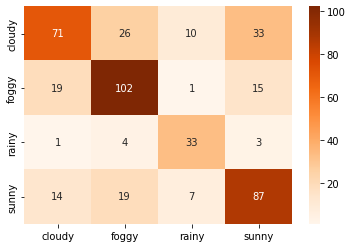

Sample 154
[[0.35616669 0.87       1.00800002]
 [0.32283336 0.77999997 1.00800002]
 [0.31316668 0.87       1.00800002]
 [0.29616669 0.89999998 1.00899994]
 [0.28116667 0.97000003 1.00800002]
 [0.27183333 0.94       1.00999999]
 [0.26166666 0.95999998 1.00899994]
 [0.26091665 0.98000002 1.00800002]
 [0.26016667 1.         1.00699997]
 [0.25216666 0.94999999 1.00899994]
 [0.24683334 1.         1.00699997]
 [0.241      1.         1.00800002]
 [0.24216667 1.         1.00800002]
 [0.26508334 1.         1.00800002]
 [0.28800002 1.         1.00800002]
 [0.33816668 0.76999998 1.00999999]
 [0.39016667 0.69999999 1.00999999]
 [0.42716664 0.77999997 1.00800002]
 [0.447      0.66000003 1.00800002]
 [0.4585     0.69999999 1.00999999]
 [0.46566668 0.66000003 1.00699997]
 [0.44633335 0.77999997 1.00600004]
 [0.44266665 0.63999999 1.00600004]
 [0.38766667 0.63999999 1.00600004]]
Predicted class:  foggy
Actual class:  foggy
Predicted precipitation:  [[0.00269926]]
Actual precipitation:  0.083333336
---

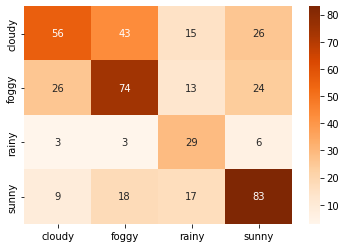

Sample 277
[[0.18516666 0.70999998 1.01400006]
 [0.20549999 0.62       1.01300001]
 [0.20966667 0.67000002 1.01300001]
 [0.20466666 0.67000002 1.01199996]
 [0.19283333 0.70999998 1.01199996]
 [0.15583333 0.81       1.01199996]
 [0.13933332 0.87       1.01199996]
 [0.138      0.81       1.01100004]
 [0.14316668 0.81       1.01199996]
 [0.15350001 0.75999999 1.01100004]
 [0.15083334 0.70999998 1.01100004]
 [0.13916667 0.75999999 1.01100004]
 [0.13266666 0.81       1.01199996]
 [0.13066667 0.75999999 1.01300001]
 [0.13016666 0.75999999 1.01300001]
 [0.12666667 0.75999999 1.01300001]
 [0.12550001 0.81       1.01300001]
 [0.1265     0.87       1.01300001]
 [0.13149999 0.87       1.01300001]
 [0.12916666 0.93000001 1.01300001]
 [0.12799999 0.93000001 1.01300001]
 [0.126      0.87       1.01300001]
 [0.12416666 0.87       1.01300001]
 [0.13249999 0.81       1.01300001]]
Predicted class:  rainy
Actual class:  rainy
Predicted precipitation:  [[0.37156054]]
Actual precipitation:  1.0
------
Samp

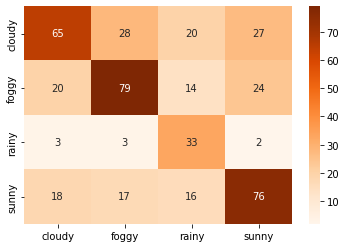

Sample 63
[[0.28516668 0.93000001 1.01300001]
 [0.29616669 0.89999998 1.01400006]
 [0.31966668 0.75999999 1.01300001]
 [0.35699999 0.60000002 1.01300001]
 [0.37933335 0.50999999 1.01300001]
 [0.37716666 0.46000001 1.01300001]
 [0.37716666 0.44999999 1.01300001]
 [0.37566668 0.41999999 1.01300001]
 [0.36733335 0.44       1.01199996]
 [0.35433334 0.47       1.01199996]
 [0.34299999 0.52999997 1.01199996]
 [0.32316667 0.61000001 1.01199996]
 [0.30533332 0.67000002 1.01199996]
 [0.29266664 0.74000001 1.01300001]
 [0.28933334 0.79000002 1.01300001]
 [0.28183332 0.81999999 1.01300001]
 [0.27950001 0.83999997 1.01300001]
 [0.264      0.98000002 1.01499999]
 [0.26733336 0.88       1.01300001]
 [0.25549999 0.99000001 1.01499999]
 [0.25850001 0.98000002 1.01499999]
 [0.26333335 0.87       1.01300001]
 [0.25916666 0.98000002 1.01499999]
 [0.25333333 0.98000002 1.01499999]]
Predicted class:  cloudy
Actual class:  foggy
Predicted precipitation:  [[0.11864769]]
Actual precipitation:  0.041666668
---

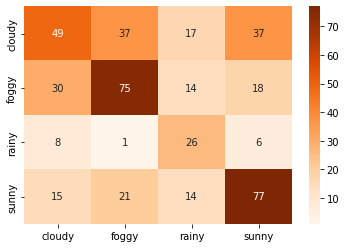

Sample 369
[[0.23666666 1.         1.01499999]
 [0.23616667 0.93000001 1.01400006]
 [0.23983334 1.         1.01499999]
 [0.24116667 0.87       1.01499999]
 [0.24883334 0.87       1.01499999]
 [0.25516668 0.81999999 1.01499999]
 [0.26533332 0.75999999 1.01499999]
 [0.28200001 0.63       1.01499999]
 [0.30499998 0.51999998 1.01499999]
 [0.30900002 0.50999999 1.01499999]
 [0.31283334 0.55000001 1.01499999]
 [0.31533334 0.50999999 1.01400006]
 [0.30900002 0.50999999 1.01400006]
 [0.29750001 0.55000001 1.01400006]
 [0.2915     0.58999997 1.02499998]
 [0.26833335 0.67000002 1.01300001]
 [0.26566666 0.58999997 1.01300001]
 [0.25549999 0.81999999 1.01300001]
 [0.24633333 0.81999999 1.01300001]
 [0.22883333 0.75999999 1.02400005]
 [0.20694532 0.86000001 1.02400005]
 [0.20623836 0.83999997 1.02400005]
 [0.17568333 0.99000001 1.02600002]
 [0.17205    0.99000001 1.02600002]]
Predicted class:  sunny
Actual class:  cloudy
Predicted precipitation:  [[0.07176674]]
Actual precipitation:  0.25
------
Sa

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow.keras as keras
import matplotlib.pyplot as plt

#root_path = '/content/drive/MyDrive/projects/weather/2021-03-11_03-00-43'
filenames = ['model_Conv1D.h5', 'model_SeparableConv1D.h5', 'model_SeparableDilatedConv1D.h5', 'model_FC.h5']

for model_filename in filenames:
  checkpoint_filepath = os.path.join(root_path, model_filename)
  model = keras.models.load_model(checkpoint_filepath)
  pred = model.predict(X_test)
  y_type_categorical = np.argmax(y_type_test, axis = 1)
  pred_categorical = np.argmax(pred[0], axis = 1)
  confm = confusion_matrix(y_type_categorical, pred_categorical, labels=None)
  print(model_filename)
  print(confm)
  df_cm = pd.DataFrame(confm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='d')
  plt.show()

  for i in range(10):
    num = np.random.randint(0, len(X_test))
    print("Sample", num)
    print(X_test[num])
    pred = model.predict(np.expand_dims(X_test[num], axis=0))
    print("Predicted class: ", labels[np.argmax(pred[0])])
    print("Actual class: ", labels[np.argmax(y_type_test[num])])
    print("Predicted precipitation: ", pred[1])
    print("Actual precipitation: ", y_precip_test[num])
    print("------")

Then we convert the best model (which you manually choose according to test results in the previous cell) to Tensorflow Lite INT8 quantized model and save it to the training folder.

In [ ]:
import tensorflow as tf

def representative_dataset():
    for i in range(100):
      data = np.expand_dims(X_test[i], axis=0)
      yield [data.astype(np.float32)]

#root_path = "/content/drive/MyDrive/projects/weather/2021-12-08_16-27-13"
model_filename = 'model_Conv1D.h5'
checkpoint_filepath = os.path.join(root_path, model_filename)
model = keras.models.load_model(checkpoint_filepath)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.int8 
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
tflite_filename = checkpoint_filepath.split('.')[0] + '.tflite'
with open(tflite_filename, 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpu5p5mlzz/assets


INFO:tensorflow:Assets written to: /tmp/tmpu5p5mlzz/assets


A good idea after conversion is check if model inference results are still correct after quantization (some accuracy loss is expected however).

In [ ]:
interpreter = tf.lite.Interpreter(model_path = tflite_filename)
interpreter.allocate_tensors()

input_scale, input_zero_point = interpreter.get_tensor_details()[0]["quantization"]
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(10):
  num = np.random.randint(0, len(X_test))

  input_data = np.asarray(X_test[num], dtype=np.float32)
  input_data_int8 =  np.asarray(input_data/input_scale + input_zero_point, dtype=np.int8)

  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data_int8, axis=0))
  interpreter.invoke()

  output_data_precip = np.asarray(interpreter.get_tensor(output_details[0]['index']), dtype=np.float32)
  output_data_type = np.asarray(interpreter.get_tensor(output_details[1]['index']), dtype=np.float32)
  print(output_data_precip, output_data_type)

  precip = (output_data_precip - input_zero_point) * input_scale
  weather_type = (output_data_type - input_zero_point) * input_scale

  print(precip, weather_type)
  print("Sample", num)
  print(str(repr(input_data.flatten())).replace("[", "{").replace("]", "}"))
  print("Predicted class: ", labels[np.argmax(weather_type[0])])
  print("Actual class: ", labels[np.argmax(y_type_test[num])])
  print("Predicted precipitation: ", precip[0][0])
  print("Actual precipitation: ", y_precip_test[num])
  print("------")

In the final cell of this notebook we write the content of .tflite file as a bytearray to a .h file to be later compiled with our sketch in Arduino IDE. You will be able to download the model from your Google Drive.

In [ ]:
tfmicro_filename = checkpoint_filepath.split('.')[0] + '.h'
!apt-get install -y xxd
!xxd -i $tflite_filename > $tfmicro_filename

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.0.1453-1ubuntu1.7).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
